# Data exploration

In [19]:
import os

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
import noswear2.dataset

In [372]:
imp.reload(noswear2.dataset)

<module 'noswear2.dataset' from '/home/nemo/Code/deepcyber/noswear-precise/noswear2/dataset.py'>

In [373]:
os.environ['NOSWEAR2_DATA_ROOT'] = '/home/nemo/Code/deepcyber/noswear-data'

In [374]:
ds = noswear2.dataset.SwearDataset(
    providers=noswear2.dataset.DEFAULT_PROVIDERS,
    good_word_path=os.path.join(noswear2.dataset.DATA_ROOT, 'good_words.txt'),
    bad_word_path=os.path.join(noswear2.dataset.DATA_ROOT, 'bad_words.txt'),
)

In [375]:
noswear2.dataset.DEFAULT_PROVIDERS

{'dictcc': {'path': '/home/nemo/Code/deepcyber/noswear-data/dictcc/download/',
  'format': 'mp3'},
 'forvo': {'path': '/home/nemo/Code/deepcyber/noswear-data/forvo/download/',
  'format': 'mp3'},
 'meriamwebster': {'path': '/home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/',
  'format': 'wav'}}

In [376]:
X, y = ds.load()

In [377]:
words, files, provider = zip(*X)

In [378]:
df = pd.DataFrame({
    'word': words,
    'file': files,
    'provider': provider,
    'swear': y,
})

In [379]:
df.sample(5)

,word,file,provider,swear
68,what,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,False
116,it,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,False
151,shit,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,True
131,when,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,False
194,fuck,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,True


In [385]:
df.swear.mean()

0.4666666666666667

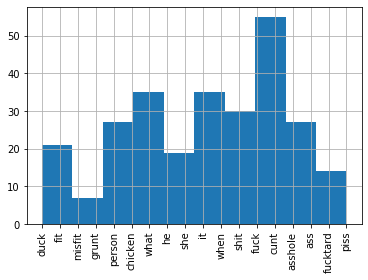

In [386]:
df.word.hist(xrot=90);

# Build precise datasets

In [231]:
def convert_mp3_to_wav(path):
    path_wav = path[:-3] + 'wav'
    if not os.path.exists(path_wav):
        os.system('sox {} {}'.format(path, path_wav))
    return path_wav

In [287]:
def build_dataset_from_df(df_train, df_test, ds_directory, overwrite=False):
    """Sort files into a mycroft-precise compatible training set using data
    from the data frame. Relevant columns in the data frame are 
    - swear (bool): is swear (=wake) word
    - file (str): path to .wav or .mp3 file (mp3 will be converted using SOX)
    """
    assert 'swear' in df_train.columns
    assert 'swear' in df_test.columns
    from shutil import copy, move
    
    if os.path.exists(ds_directory) and not overwrite:
        print('Directory already exists. Skipping.')
        return
    else:
        os.makedirs(ds_directory, exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'not-wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'test', 'wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'test', 'not-wake-word'), exist_ok=True)
    
    for is_train, df in zip((True, False), (df_train, df_test)):
        for idx, path, is_swear in df[['file', 'swear']].itertuples():
            print(f'{path} swear={is_swear} train={is_train}')

            if path.endswith('.mp3'):
                path = convert_mp3_to_wav(path)
                op = move
            else:
                op = copy

            subdir = '.' if is_train else 'test'
            class_dir = 'wake-word' if is_swear else 'not-wake-word'
            name = os.path.basename(path)
            target_dir = os.path.join(ds_directory, subdir, class_dir)

            op(path, os.path.join(target_dir, name))

In [288]:
def df_train_test_split(df):
    train_idx, test_idx = train_test_split(df.index, random_state=42, stratify=df.word)
    return df.loc[train_idx], df.loc[test_idx]

## "fuck" and all others in validation

In [387]:
simple_mask = df.word.isin(['fuck'])
df_simple = df[simple_mask]

df_simple_train, df_simple_test = df_train_test_split(df_simple)

# append all non-fuck samples to the test set
df_simple_test = df_simple_test.append(df[~simple_mask])

In [392]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(noswear2.dataset.DATA_ROOT, 'datasets', 'fuck_only'), 
    overwrite=True)

/home/nemo/Code/deepcyber/noswear-data/dictcc/download/when_0.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/it_1.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_2.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/it_2.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/when_1.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_18.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/duck_01.wav swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_7.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_26.mp3 swear=True train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/it_2.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/when_12.mp3 swear=False train=True
/home/nemo/Code/deepcyb

/home/nemo/Code/deepcyber/noswear-data/forvo/download/misfit_1.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/misfit_0.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/chicken_14.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/person_4.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_11.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/fit_3.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/chicken_0.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_17.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_21.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_2.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_14.mp3 swear=False train=True
/home/nemo/Cod

## "fuck" and non-swear words in train

In [393]:
simple_mask = df.word.isin(['fuck']) | ~df.swear
df_simple = df[simple_mask]
df_simple_train, df_simple_test = df_train_test_split(df_simple)

In [394]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(noswear2.dataset.DATA_ROOT, 'datasets', 'fuck_and_non_swear'), 
    overwrite=True)

/home/nemo/Code/deepcyber/noswear-data/dictcc/download/when_0.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/it_1.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_2.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/it_2.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/when_1.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_18.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/meriamwebster/download/duck_01.wav swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/duck_7.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/fuck_26.mp3 swear=True train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/it_2.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/when_12.mp3 swear=False train=True
/home/nemo/Code/deepcyb

/home/nemo/Code/deepcyber/noswear-data/forvo/download/person_4.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_11.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/fit_3.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/dictcc/download/chicken_0.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_17.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_21.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_2.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_14.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/what_9.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/person_5.mp3 swear=False train=True
/home/nemo/Code/deepcyber/noswear-data/forvo/download/when_13.mp3 swear=False train=True
/home/nemo/Code/deep